* Upsampling (higher L)
* More slices (higher N)
* Fewer data slices than candidate rotations (N < Ngrid)
* High number of candidate rotations but like 2 rotations
* Which great circles are picked?

In [22]:
import sys
sys.path.append("/home/emastr/moment-constrained-cryo-em/src/")

from single_degree_alignment import *
from geometry import *
from single_degree_plot import *
from single_degree_interpolation import *

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.33953051 -2.43787504  0.33953051  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


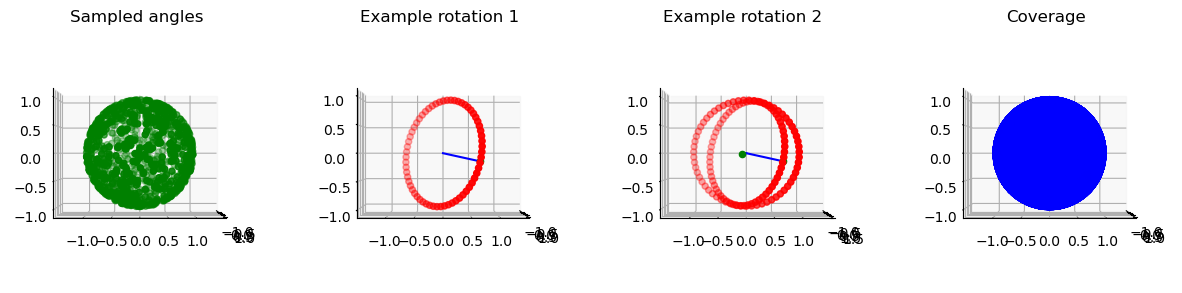

In [23]:
base_key = jax.random.PRNGKey(10)

# Indices
Lmax = 31
ls, ms = get_l_and_m(Lmax)
eval_shell_wrap = lambda thetas, phis, fm: eval_shell(thetas, phis, fm, ls, ms, Lmax)

# Interpolation grid
sampling_interp = "mw"
phis = s2fft.sampling.s2_samples.phis_equiang(Lmax+1, sampling_interp)
thetas = s2fft.sampling.s2_samples.thetas(Lmax+1, sampling_interp)
phis_grid, thetas_grid = jnp.meshgrid(phis, thetas, indexing="ij")

# Random signal
base_key, key = jax.random.split(base_key)
fm = random_signal(Lmax, key)

fm = fm.at[:Lmax - 1].set(0.)
fm = fm.at[Lmax+2:].set(0.)
fm_norm = jnp.linalg.norm(fm)

print(fm.imag)
#fm = 0*fm
#fm = fm.at[Lmax].set(1j)

f = vmap(vmap(lambda theta, phi: eval_shell(theta, phi, fm, ls, ms, Lmax), (0, None)), (None, 0))(thetas, phis)

def project(f):
    return f / jnp.linalg.norm(f) * fm_norm

# Reference grid
#Alphas = phis_grid.flatten()
#Betas = thetas_grid.flatten() 
#Gammas = jnp.zeros_like(Alphas)

Ngrid = 1000
Alphas, Betas, _ = random_so3(key, Ngrid)
Gammas = jax.random.randint(key, (Ngrid,), 0, 2*Lmax) * 2 * jnp.pi / (2*Lmax + 1)
d_betas, sph_zero = get_slicing_weights(Betas, ms, Lmax)
fm_rot_slices = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas, d_betas, Gammas, ms, sph_zero)
f_rot_slices = vmap(sph_slice_to_vals, (0, None))(fm_rot_slices, Lmax)

# Random rotations
Nrots = 2
base_key, key = jax.random.split(base_key)
#Alphas_data, Betas_data, Gammas_data = random_so3(key, Nrots)

#rnd_idx = jax.random.randint(key, (Nrots,), 0, len(Alphas))
#gam_idx = jax.random.randint(key, (Nrots,), 0, 2*Lmax)
#Alphas_data = Alphas[rnd_idx]
#Betas_data = Betas[rnd_idx]
#Gammas_data = gam_idx * 2*jnp.pi / (2*Lmax + 1) #jnp.zeros_like(Alphas_data) #jax.random.uniform(key, (Nrots,))*2*jnp.pi

#Alphas_data = Alphas_data.at[:Ngrid].set(Alphas)
#Betas_data = Betas_data.at[:Ngrid].set(Betas)
#Gammas_data = Gammas_data.at[:Ngrid].set(Gammas)

Alphas_data = Alphas[:Nrots]
Betas_data = Betas[:Nrots]
Gammas_data = Gammas[:Nrots]

d_betas_data, sph_zero = get_slicing_weights(Betas_data, ms, Lmax)
fm_rot_slices_data = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas_data, d_betas_data, Gammas_data, ms, sph_zero)
f_rot_slices_data = vmap(sph_slice_to_vals, (0, None))(fm_rot_slices_data, Lmax)

plot_rot(Alphas, Betas, Gammas, (2*Lmax+1))

In [24]:
f_rot_slices_est = align_data_to_slices_average(fm_rot_slices, f_rot_slices_data, fm_rot_slices_data)
fm_rot_slices_est = vmap(sph_vals_to_slice, (0, None))(f_rot_slices_est, Lmax)
lsq_solve, matvec = precompute_lsq(Alphas, Betas, Gammas, ms, Lmax)
print(f"Error between aligned data and true slices: {jnp.linalg.norm(fm_rot_slices_est - fm_rot_slices)}")
print(f"Error between true signal and lsq signal: {jnp.linalg.norm(lsq_solve(f_rot_slices_est.reshape(-1)) - fm)}")

Error between aligned data and true slices: nan
Error between true signal and lsq signal: nan


In [25]:
def loss1(fm_est):
    fm_rot_slices_est = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm_est, Alphas, d_betas, Gammas, ms, sph_zero)
    
    # Align data_to_slices_average(fm_rot_slices_est, f_rot_slices_data, fm_rot_slices_data)
    data, fft_data = f_rot_slices_data, fm_rot_slices_data    
    vmap_aligns = vmap(align_data_to_slices, (None, 0, 0))
    aligned_data, slice_idx = vmap_aligns(fm_rot_slices_est, data, fft_data)
    conditional_mean = lambda idx: jnp.sum(jnp.where(slice_idx[:, None] == idx, aligned_data, jnp.zeros_like(aligned_data)), axis=0)/jnp.sum(slice_idx == idx)
    
    idx_vec = jnp.arange(fm_rot_slices_est.shape[0])
    mean = vmap(conditional_mean)(idx_vec)
    mean = jnp.where(jnp.isnan(mean), 0, mean)
    count = vmap(lambda idx: jnp.sum(slice_idx == idx))(idx_vec)
    count = count[:,None] + 0*mean
    # over

    f_rot_slices_est = mean
    fm_est = project(fm_est)
    rhs = f_rot_slices_est.reshape(-1)
    return jnp.linalg.norm(count.reshape(-1)*(matvec(fm_est) - rhs))
    #return jnp.linalg.norm(count.reshape(-1)*(jnp.where(rhs!=0, matvec(fm_est) - rhs, 0.)))
    #return jnp.linalg.norm((matvec(fm_est) - f_rot_slices_est.reshape(-1)))

def loss2(fm_est):
    fm_rot_slices_est = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm_est, Alphas, d_betas, Gammas, ms, sph_zero)
    f_rot_slices_est = align_data_to_slices_average(fm_rot_slices_est, f_rot_slices_data, fm_rot_slices_data)
    f_rot_slices_est = jnp.where(jnp.isnan(f_rot_slices_est), 0, f_rot_slices_est)
    fm_est = project(fm_est)
    return jnp.linalg.norm(jnp.where(f_rot_slices_est.reshape(-1)!=0, matvec(fm_est) - f_rot_slices_est.reshape(-1),0))


loss = loss1

thetas = jnp.linspace(0, jnp.pi, 50)
phis = jnp.linspace(0, 2*jnp.pi, 50)
thetas, phis = jnp.meshgrid(thetas, phis, indexing="ij")
(x, y, z) = sph2cart(thetas.flatten(), phis.flatten(), r=jnp.linalg.norm(fm))

fm_mat = 1j * jnp.array([x, y, z]).T

def pad(fm):
    return jnp.concatenate([jnp.zeros((len(fm), Lmax-1)), fm, jnp.zeros((len(fm), Lmax-1))], axis=1)

def sph2signal(theta, phi):
    zeros = jnp.zeros((Lmax-1,))
    middle = jnp.array(sph2cart(theta, phi, r=fm_norm))
    return 1j * jnp.concatenate([zeros, middle, zeros])


fm_matmat = vmap(vmap(sph2signal, (0,0)), (0,0))(thetas, phis)

def row_wise_loss(fm_matmat):
    losses = []
    for (i,fm_mat) in enumerate(fm_matmat):
        losses.append(vmap(loss)(fm_mat))
        print(f"row {i} done out of {len(fm_matmat)}", end="\r")
    return jnp.array(losses)





In [26]:
#print(sph2signal(0,0).shape)    
#print(fm_matmat.shape)

losses = row_wise_loss(fm_matmat)
#fm_mat = pad(fm_mat)
#losses = vmap(loss)(fm_mat)

print(jnp.max(losses), jnp.min(losses), loss(fm))
theta_true, phi_true = cart2sph(*fm[Lmax-1:Lmax+2].imag)

14.603299789609341 0.3469726624567771 5.301542400474002e-13


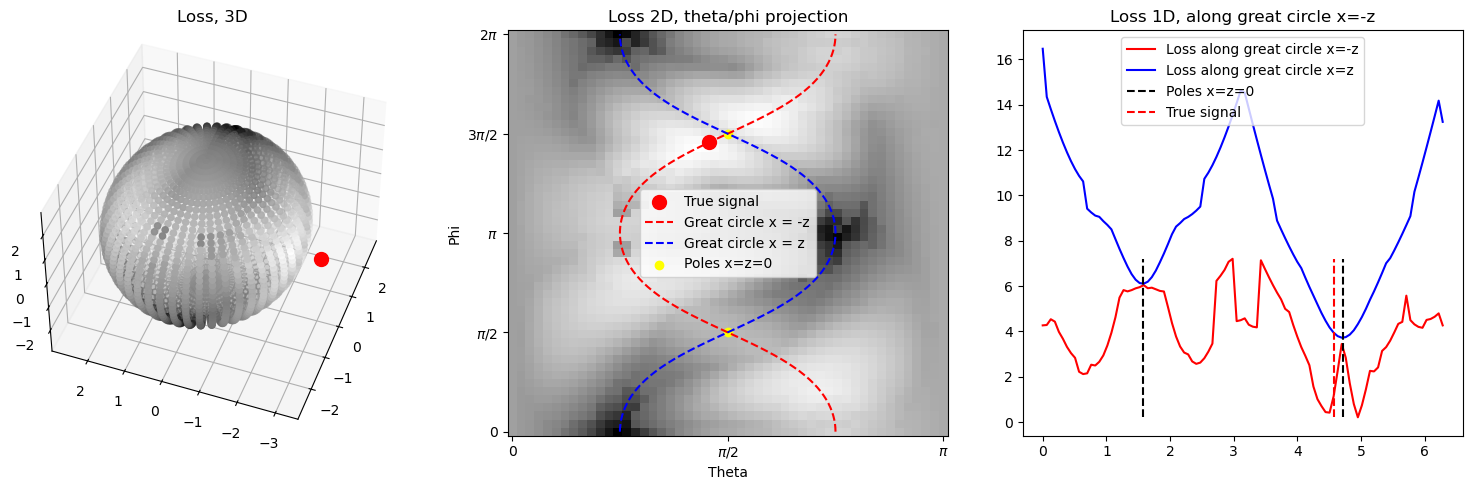

In [27]:
def colormap(x,y,z,values):
    weights = (values - jnp.min(values))/(jnp.max(values) - jnp.min(values))
    #colors = jnp.array([1, 0, 0]) * weights[:,None] + jnp.array([0, 0, 1]) * (1-weights[:, None])
    colors = jnp.array([1, 1, 1]) *(1- weights[:,None])# + jnp.array([0, 0, 1]) * (1-weights[:, None])
    #colors = jnp.where(jnp.linalg.norm(jnp.array([x,y,z])-fm.imag)<0.1, jnp.zeros_like(colors), colors)
    return colors


plt.figure(figsize=(15,5))

ax = plt.subplot(131, projection='3d')
plt.title("Loss, 3D")
ax.scatter(x, y, z, color=colormap(x,y,z,losses.flatten()))
ax.scatter(*fm[Lmax-1:Lmax+2].imag*1.3, s=100, color="red")
ax.view_init(elev=45, azim=200)

plt.subplot(132)
phi = jnp.linspace(0, 2*jnp.pi, 100)
theta = jnp.arctan(-1/jnp.cos(phi)) % jnp.pi
theta_inv = -theta + jnp.pi
theta1, phi1 = cart2sph(0, 1, 0)
theta2, phi2 = cart2sph(0, -1, 0)
#plt.scatter(thetas.flatten(), phis.flatten(), c=colormap(x,y,z,losses), label="Loss")
plt.title("Loss 2D, theta/phi projection")
plt.pcolormesh(thetas, phis, losses.reshape(thetas.shape), cmap="Greys", label="loss")
plt.scatter(theta_true, phi_true, s=100, color="red", zorder=10, label="True signal")
# Plot great circle x = -z, i.e. in the plane with normal (1, 0, -1):
# x = -z -> sin(phi)sin(theta) = -cos(theta) -> tan(theta) = 1/sin(phi) -> theta = arctan(1/sin(phi)) 
plt.plot(theta, phi, label="Great circle x = -z", color="red", linestyle="--")
plt.plot(theta_inv, phi, label="Great circle x = z", color="blue", linestyle="--")
plt.scatter(theta1, phi1, color='yellow', label="Poles x=z=0")
plt.scatter(theta2, phi2, color='yellow')
plt.xlabel("Theta")
plt.ylabel("Phi")
plt.yticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
plt.xticks([0, jnp.pi/2, jnp.pi], ["0", r"$\pi/2$", r"$\pi$"])
plt.legend()

plt.subplot(133)
plt.title("Loss 1D, along great circle x=-z")
loss_circle = vmap(lambda theta, phi: loss(sph2signal(theta, phi)), (0,0))(theta, phi)
loss_inv_circle = vmap(lambda theta, phi:  loss(sph2signal(theta, phi)), (0,0))(theta_inv, phi)

plt.plot(phi, loss_circle, color="red", label="Loss along great circle x=-z")
plt.plot(phi, loss_inv_circle, color="blue", label="Loss along great circle x=z")
plt.plot([phi1, phi1], [jnp.min(loss_circle), jnp.max(loss_circle)], color="black", linestyle="--", label="Poles x=z=0")
plt.plot([phi2, phi2], [jnp.min(loss_circle), jnp.max(loss_circle)], color="black", linestyle="--")
plt.plot([phi_true, phi_true], [jnp.min(loss_circle), jnp.max(loss_circle)], color="red", linestyle="--", label="True signal")
#plt.xlim([phi_true-0.1, phi_true+0.1])
plt.legend()

plt.tight_layout()
